<a href="https://colab.research.google.com/github/KenObata/Music4All_personal_project/blob/main/music4all_multi_class_by_genre_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week3: The goal of this notebook is to apply TF-IDF, statistical machine learning approach to the lyrics datasets. In week2 notebook, multi-label classification of genre and language did not have a good accuracy, so this notebook transforms multi-label problem into multi-class single label problem by first filtering a language, then apply TF-IDF vector->StratifiedKFold->fit() by multinomialNB->predict()->check accuracy.


In [1]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
!pip install scikit-multilearn

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [4]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [5]:
def analyze_genre_tag_df(df, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[1]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, top_n=top_n)

# Find top20 genre

id_genres.csv

Number of genres: 853


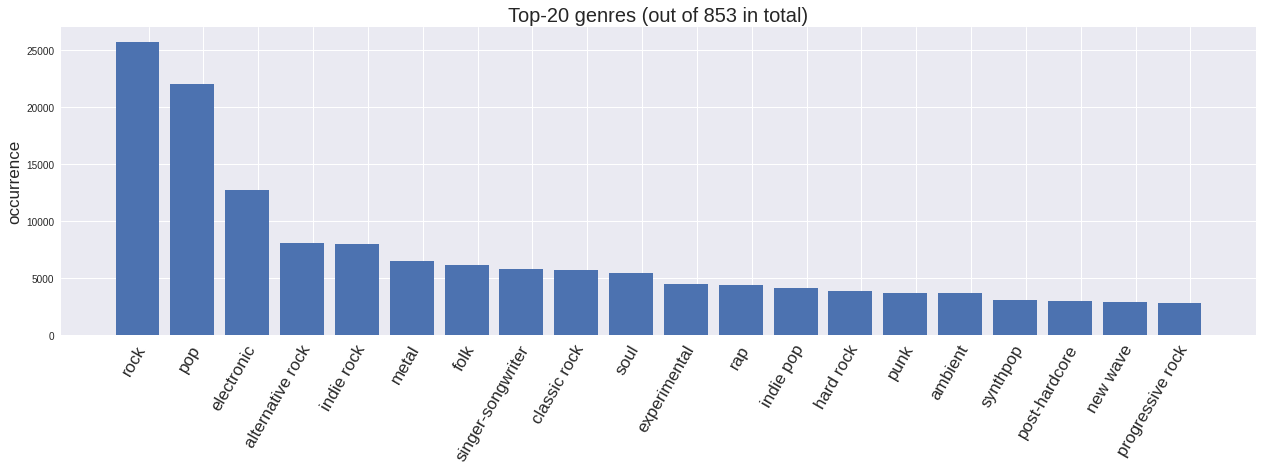

In [ ]:
_ = analyze_genre_tag_csv('id_genres.csv', top_n=20)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

In [6]:
#create List of top20 genre
top20_genre=["rock","pop", "electronic","alternative rock","indie rock", 
              "metal","folk","singer-songwriter","classic rock","soul"
              ,"experimental","rap","indie pop","hard rock","punk"
              ,"ambient","synthpop","post-hardcore","new wave","progressive rock"]

#filter genre dataset as top20 genre only.
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_genre_top20 = df_genres[df_genres['genres'].isin(top20_genre)]
df_genre_top20

,id,genres
0,0009fFIM1eYThaPg,pop
11,00P2bHdWFkghmDqz,soul
14,00XWljDxNBgBKEEA,pop
16,00b6fV3nx5z2b8Ls,pop
26,013QDoTqbexEwkHr,pop
...,...,...
109253,zzgS4ZqyswamEWNj,pop
109254,zziALZG1JQ2uUjcy,metal
109262,zzx8CWdM7qkxKQpC,indie rock
109265,zzz0n04uuTUA7fNh,pop


Number of genres: 20


Counter({'alternative rock': 384,
         'ambient': 330,
         'classic rock': 185,
         'electronic': 1305,
         'experimental': 257,
         'folk': 1017,
         'hard rock': 203,
         'indie pop': 714,
         'indie rock': 1182,
         'metal': 175,
         'new wave': 169,
         'pop': 6092,
         'post-hardcore': 267,
         'progressive rock': 234,
         'punk': 402,
         'rap': 1431,
         'rock': 1887,
         'singer-songwriter': 794,
         'soul': 1337,
         'synthpop': 238})

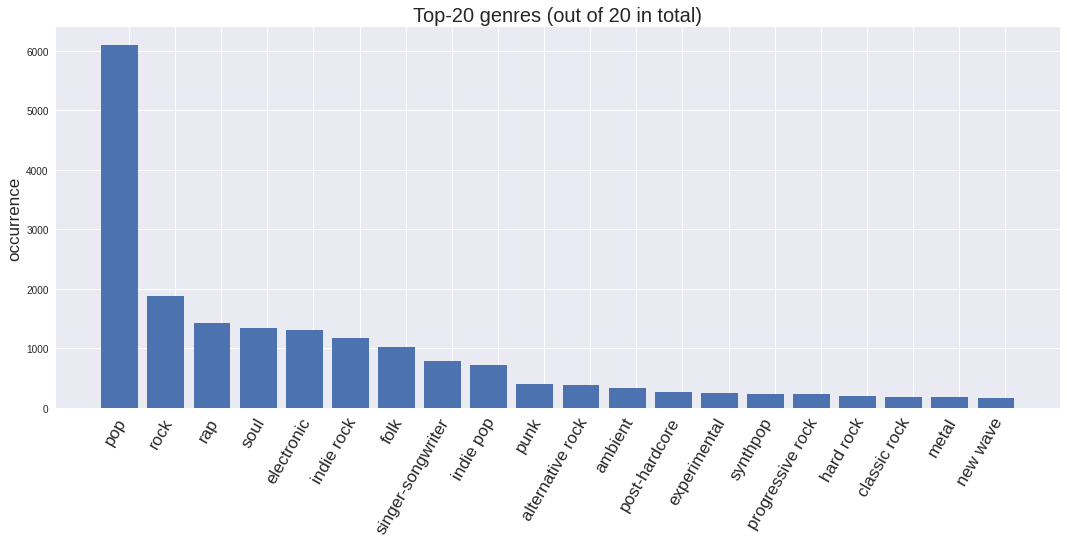

In [7]:
analyze_genre_tag_df(df_genre_top20,20)

Dataframe narrowed down to 18603 rows. Notice that rank20 has only 169 data. So depending on the result we might need to narrow down to top10 genre?

# find top10 language

Number of lang: 46
Counter({'en': 84103, 'INTRUMENTAL': 9417, 'pt': 7020, 'es': 3225, 'ko': 1145, 'fr': 994, 'ja': 615, 'de': 577, 'pl': 446, 'it': 437, 'sv': 231, 'ru': 187, 'id': 140, 'tr': 125, 'fi': 105, 'no': 99, 'nl': 59, 'tl': 42, 'hr': 41, 'hu': 27, 'sw': 21, 'uk': 20, 'el': 18, 'ca': 18, 'ro': 18, 'da': 17, 'ar': 17, 'et': 16, 'so': 16, 'vi': 13, 'af': 8, 'lt': 7, 'cy': 7, 'sl': 7, 'fa': 6, 'sq': 5, 'th': 4, 'zh-cn': 4, 'pa': 2, 'lv': 2, 'bn': 2, 'cs': 2, 'hi': 1, 'sk': 1, 'bg': 1, 'he': 1})


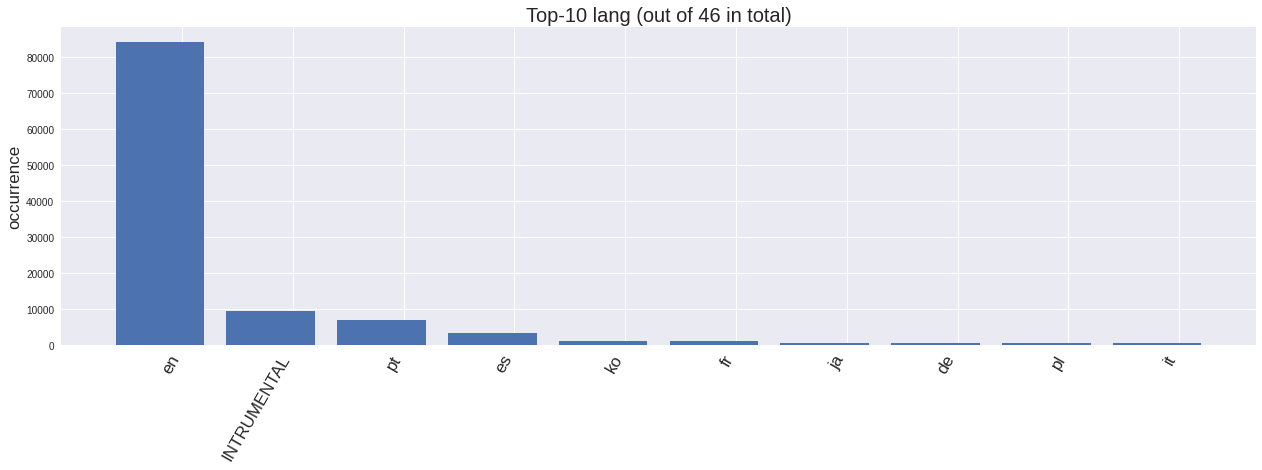

In [7]:
labels_counter = analyze_genre_tag_csv('id_lang.csv', top_n=10)
print(labels_counter)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-language.png'))

In [8]:
# create List of top10 language, except INTRUMENTAL
top_10_lang = ['en', 'pt', 'es', 'ko', 'fr', 'ja', 'de', 'pl', 'it']
en_lang =['en']

# Filter only English
 Note that this split have overlapping artist in both sets. See artist-grouped-stratified-split for an improved version.

In [9]:
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_lang_en

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


Originally it was 109269 rows, and now there are 84103 rows.

### Now, combine split by language and genre, so we classify each genre by language.

In [10]:
# merge three dataframes into one
df_genre_by_lang = pd.concat([df_genre_top20['id'], df_genre_top20['genres'], df_lang_en['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_by_lang


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
30,01EKNot8qVgZpKM7,rock,en
...,...,...,...
109253,zzgS4ZqyswamEWNj,pop,en
109254,zziALZG1JQ2uUjcy,metal,en
109262,zzx8CWdM7qkxKQpC,indie rock,en
109265,zzz0n04uuTUA7fNh,pop,en


### Important Note: after filtering/sorting or any data manipulation on datasets, we need to reindex data frame. Otherwise, multi-label stratification fails due to shape mismatch of X and y.

In [11]:
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)
df_genre_by_lang

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,00P2bHdWFkghmDqz,soul,en
2,00b6fV3nx5z2b8Ls,pop,en
3,013QDoTqbexEwkHr,pop,en
4,01EKNot8qVgZpKM7,rock,en
...,...,...,...
15425,zzgS4ZqyswamEWNj,pop,en
15426,zziALZG1JQ2uUjcy,metal,en
15427,zzx8CWdM7qkxKQpC,indie rock,en
15428,zzz0n04uuTUA7fNh,pop,en


In [12]:
len(set(df_genre_by_lang['genres']))

20

Number of genres: 20


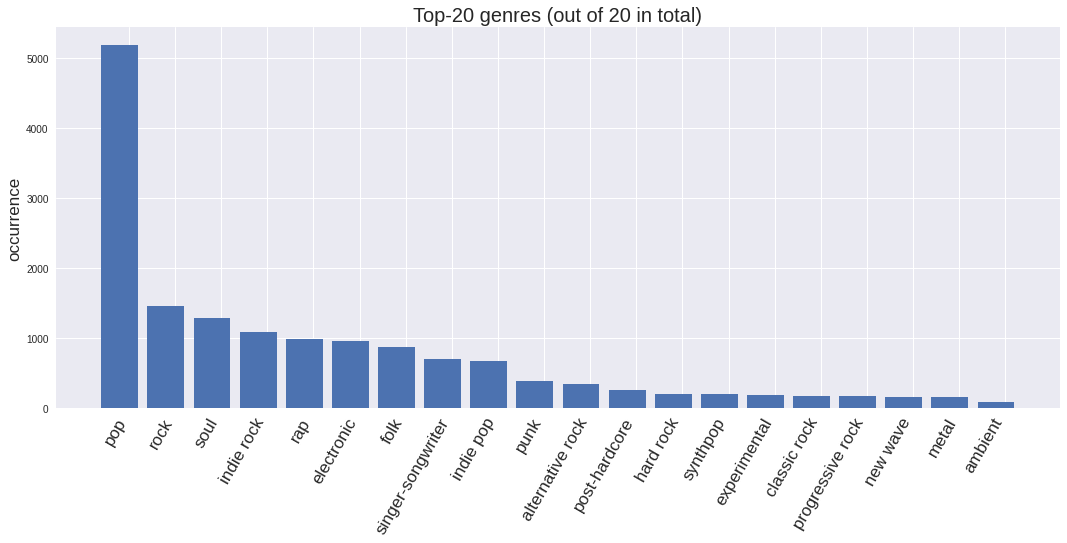

In [12]:
#Analyze genres of English: drop a genre if it is less than 500?
labels = analyze_genre_tag_df(df_genre_by_lang,20)


In [13]:
sorted_genres=sorted(labels.items(), key=lambda pair: pair[1], reverse=True)
sorted_genres 

[('pop', 5179),
 ('rock', 1449),
 ('soul', 1288),
 ('indie rock', 1081),
 ('rap', 978),
 ('electronic', 953),
 ('folk', 863),
 ('singer-songwriter', 695),
 ('indie pop', 672),
 ('punk', 382),
 ('alternative rock', 338),
 ('post-hardcore', 253),
 ('hard rock', 195),
 ('synthpop', 191),
 ('experimental', 180),
 ('classic rock', 167),
 ('progressive rock', 167),
 ('new wave', 160),
 ('metal', 157),
 ('ambient', 82)]

Looking at the sorted genres, we can drop the genres which occured less than 200.


In [14]:
#create a narrowed down genre
genre_list=[]
for genre, count in sorted_genres:
  if count > 200:
    genre_list.append(genre)
genre_list

['pop',
 'rock',
 'soul',
 'indie rock',
 'rap',
 'electronic',
 'folk',
 'singer-songwriter',
 'indie pop',
 'punk',
 'alternative rock',
 'post-hardcore']

#### So, filter genres of frequent occurence only

In [15]:
df_genre_by_lang=df_genre_by_lang[ df_genre_by_lang['genres'].isin(genre_list) ]
df_genre_by_lang

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,00P2bHdWFkghmDqz,soul,en
2,00b6fV3nx5z2b8Ls,pop,en
3,013QDoTqbexEwkHr,pop,en
4,01EKNot8qVgZpKM7,rock,en
...,...,...,...
15424,zzT504Z94j1IAuc3,indie rock,en
15425,zzgS4ZqyswamEWNj,pop,en
15427,zzx8CWdM7qkxKQpC,indie rock,en
15428,zzz0n04uuTUA7fNh,pop,en


### Get lyrics document as dataframe and append to X_train, X_test

In [16]:
#create lyric column
df_genre_by_lang["lyric"] = ""
df_genre_by_lang

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,
1,00P2bHdWFkghmDqz,soul,en,
2,00b6fV3nx5z2b8Ls,pop,en,
3,013QDoTqbexEwkHr,pop,en,
4,01EKNot8qVgZpKM7,rock,en,
...,...,...,...,...
15424,zzT504Z94j1IAuc3,indie rock,en,
15425,zzgS4ZqyswamEWNj,pop,en,
15427,zzx8CWdM7qkxKQpC,indie rock,en,
15428,zzz0n04uuTUA7fNh,pop,en,


In [19]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Archive:  drive/MyDrive/music4all/lyrics.zip
replace /content/lyrics/0009fFIM1eYThaPg.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [18]:
#index 5001 ~ 10,000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[5001:10000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [19]:
#index 10001 ~ 18345
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[10001:18345].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [20]:
#Reindex again
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)

In [21]:
df_genre_by_lang[0:14131]

,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,"It's a sunny day, so I got nowhere to hide Not..."
1,00P2bHdWFkghmDqz,soul,en,"Tell me a tale that always was, Sing me a song..."
2,00b6fV3nx5z2b8Ls,pop,en,A buh-buh buh buh-buh A buh-buh buh buh-buh Y...
3,013QDoTqbexEwkHr,pop,en,"It's like a conversation, where no-one stops t..."
4,01EKNot8qVgZpKM7,rock,en,Say the words I cannot say Say them on another...
...,...,...,...,...
14126,zzT504Z94j1IAuc3,indie rock,en,Don't think it's what you're afraid of come in...
14127,zzgS4ZqyswamEWNj,pop,en,"Oh, yeah, yeah Last night I took a walk in th..."
14128,zzx8CWdM7qkxKQpC,indie rock,en,"Innocence, it don't come easy, in a sense it n..."
14129,zzz0n04uuTUA7fNh,pop,en,Girl you don't know how I feel (how I really f...


In [32]:
write_txt("/content/df_genre_en.txt", 
          list_of_str=[str(row) for index, row in df_genre_by_lang.iterrows()]
          )

### Create y as y_dense

In [22]:
from sklearn.preprocessing import LabelBinarizer
y=np.array(df_genre_by_lang['genres'])

y_dense = LabelBinarizer().fit_transform(y)
print(y_dense)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


### Run the multi-class classification

### Try splitStratifiedKFold with feature

In [23]:
from sklearn.preprocessing import LabelBinarizer

def StratifiedKFold_feature_and_df(Xfeatures, df, y_name):
  skf = StratifiedKFold(n_splits=5)  # 20% for test set 
  # In the above code, I removed from random_state=1209 due to an error message
  #try label encoder
  y=np.array(df[y_name])
  y_dense = LabelBinarizer().fit_transform(y)
  
  skf.get_n_splits(Xfeatures, y)

  splits = []

  for train_index, test_index in skf.split(Xfeatures, y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = Xfeatures[train_index], Xfeatures[test_index]
      y_train, y_test = y[train_index], y[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

### I found that without specifying token_pattern=r'\b\w+\b', it contains some useless words such as numbers. 

In [24]:
#Try this
#build default uni-gram of TF-IDF
from sklearn.metrics import accuracy_score,hamming_loss,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
Xfeatures = tfidf.fit_transform(df_genre_by_lang['lyric']).toarray()
Xfeatures

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
Xfeatures.shape

(14131, 37224)

I used to be 38,000 features, so token_pattern=r'\b\w+\b' removed about 1000 unnecessaly words.

In [40]:
df_genre_by_lang.shape

(14131, 4)

In [41]:
splits = StratifiedKFold_feature_and_df(Xfeatures, df_genre_by_lang, 'genres')
len(splits)

TRAIN: [ 2535  2549  2555 ... 14128 14129 14130] TEST: [   0    1    2 ... 2964 2970 2975]
TRAIN: [    0     1     2 ... 14128 14129 14130] TEST: [2535 2549 2555 ... 6011 6019 6024]
TRAIN: [    0     1     2 ... 14128 14129 14130] TEST: [5126 5232 5242 ... 8798 8812 8825]
TRAIN: [    0     1     2 ... 14128 14129 14130] TEST: [ 8240  8279  8289 ... 11504 11555 11625]
TRAIN: [    0     1     2 ... 11504 11555 11625] TEST: [10985 11025 11037 ... 14128 14129 14130]


5

In [42]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
#X_train, X_test, y_train, y_test = split0['X_train']
from sklearn.naive_bayes import MultinomialNB
import numpy as np
#Step4: Create MultinomialNB classifier and fit()
clf = MultinomialNB().fit(split0['X_train'], split0['y_train'])

(11304, 37224)
(11304,)


In [43]:
predicted = clf.predict(split0['X_test'])

In [44]:
np.set_printoptions(threshold=np.inf)
print(predicted)

['pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop'
 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'pop' 'p

In [45]:
print(np.mean(predicted == split0['y_test']))

0.36858860983374603


### More detail evaluation, precision, recall, f-score

In [46]:
from sklearn import metrics
#split0['y_test'], predicted
print(metrics.classification_report(split0['y_test'], predicted) )
                                   # ,target_names=target_names_list) )

                   precision    recall  f1-score   support

 alternative rock       0.00      0.00      0.00        68
       electronic       0.00      0.00      0.00       190
             folk       0.00      0.00      0.00       173
        indie pop       0.00      0.00      0.00       135
       indie rock       0.00      0.00      0.00       216
              pop       0.37      1.00      0.54      1036
    post-hardcore       0.00      0.00      0.00        51
             punk       0.00      0.00      0.00        76
              rap       1.00      0.03      0.06       195
             rock       0.00      0.00      0.00       290
singer-songwriter       0.00      0.00      0.00       139
             soul       0.00      0.00      0.00       258

         accuracy                           0.37      2827
        macro avg       0.11      0.09      0.05      2827
     weighted avg       0.20      0.37      0.20      2827



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Almost all predictions are pop, which is not good. We need to think how to avoid mis prediction of pop.

### More analysis: which word frequently appear after TF-IDF?


In [47]:
tfidf.get_feature_names_out()

array(['0', '00', '000', '01', '02', '03', '05', '06', '07', '08', '09',
       '1', '10', '100', '1000', '100k', '101', '1017', '103', '104',
       '105', '106', '1080', '109', '10cc', '10g', '10k', '10th', '11',
       '110', '112th', '115', '118', '119', '11s', '12', '120', '1223',
       '123', '125', '127', '12am', '12p', '12th', '13', '134', '13th',
       '13x', '14', '140', '1400', '1415', '149', '14s', '14th', '15',
       '150', '151', '155', '15s', '15th', '16', '16th', '16마디', '17',
       '1738', '175', '17th', '18', '180', '1805', '182', '1852', '187',
       '18th', '19', '1925', '1934', '1947', '1950', '1952', '1962',
       '1963', '1964', '1965', '1967', '1968', '1970', '1970s', '1972',
       '1974', '1975', '1976', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1991',
       '1992', '1993', '1994', '1995', '1997', '1998', '1999', '19xb',
       '1am', '1d', '1da', '1s', '1st', '1x', '2', '20', '200', '2000',


### (If we do not use binary label, and simply run multi-class classifier) Now that we have train and test split, run count vector (unigram) then apply TF-IDF. Take mean of accuracy of Stratified5Fold

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

for split in splits:
  #Step1: Get Train(including labels, y) and Test
  df_genre_by_lang_train = df_genre_by_lang.iloc[split['train']]
  df_genre_by_lang_test = df_genre_by_lang.iloc[split['test']]

  #Step2: Count Vector
  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(df_genre_by_lang_train['lyric'])

  #Step3: Apply TF-IDF
  tfidf_transformer = TfidfTransformer()
  X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

  #Step4: Create MultinomialNB classifier and fit()
  clf = MultinomialNB().fit(X_train_tfidf, df_genre_by_lang_train['genres'])

  #Step5: Predict (Test)
  docs_test = df_genre_by_lang_test['lyric']
  X_test_counts = count_vect.transform(docs_test)
  X_test_tfidf = tfidf_transformer.transform(X_test_counts)

  predicted = clf.predict(X_test_tfidf)

  print(np.mean(predicted == df_genre_by_lang_test['genres']))


0.36858860983374603
0.36978060863411183
0.3708421797593772
0.36907289455060155
0.37119603680113233
